<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [6]:
# !pip install "tensorflow>=2.0.0"
# !pip install --upgrade tensorflow-hub

# !pip install -U tensorflow-text==2.15.0

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [11]:
import pandas as pd

df = pd.read_csv("spam_ham_dataset.csv")
df.head(5)
df.tail(10)

,Unnamed: 0,label,text,label_num
5161,4979,spam,Subject: penny stocks are about timing\r\nnoma...,1
5162,4162,spam,Subject: anomaly boys from 3881\r\nuosda apapr...,1
5163,1428,ham,Subject: re : meter # : 1266 ; august 2000 / a...,0
5164,4365,spam,Subject: slutty milf wants to meet you\r\ntake...,1
5165,2849,ham,"Subject: fw : crosstex energy , driscoll ranch...",0
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0
5170,4807,spam,Subject: important online banking alert\r\ndea...,1


In [12]:
df.groupby('label').describe()

Unnamed: 0                                                         \
           count    mean          std     min      25%     50%      75%   
label                                                                     
ham       3672.0  1835.5  1060.159422     0.0   917.75  1835.5  2753.25   
spam      1499.0  4421.0   432.868340  3672.0  4046.50  4421.0  4795.50   

              label_num                                     
          max     count mean  std  min  25%  50%  75%  max  
label                                                       
ham    3671.0    3672.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
spam   5170.0    1499.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [13]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [14]:
1499/(3672+1499)

0.2898859021465867

**29% spam emails, 71% ham emails: This indicates class imbalance**

In [15]:
df_spam = df[df['label']=='spam']
df_spam = df_spam[['text','label']]
df_spam.shape

(1499, 2)

In [16]:
df_ham = df[df['label']=='ham']
df_ham = df_ham[['text','label']]
df_ham.shape

(3672, 2)

In [17]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1499, 2)

In [18]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape
df_balanced.head()

,text,label
4204,Subject: tejas nomination change effective 7 /...,ham
5022,"Subject: hpl nom for may 3 , 2001\r\n( see att...",ham
3281,Subject: follow - up\r\njust following up to m...,ham
1921,"Subject: enron / hpl actuals for december 18 ,...",ham
2489,Subject: increase volume into midcon\r\n- - - ...,ham


In [19]:
df_balanced['label'].value_counts()

label
ham     1499
spam    1499
Name: count, dtype: int64

In [20]:
df_balanced['spam']=df_balanced['label'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,text,label,spam
494,Subject: get your college degree online !\r\n,spam,1
3875,Subject: \r\nyou gotta check out h g hormone d...,spam,1
4322,Subject: business proposal .\r\nfrom : alhaji ...,spam,1
2020,Subject: can jim come over and watch ?\r\nup t...,spam,1
2829,Subject: = ? iso - 8859 - 7 ? q ? = 5 b = 3 f ...,spam,1


<h4>Text preprocessing</h4>


In [21]:
# Removing the "Subject:" word
import re
def remove_word(text):
    return re.sub(r'^Subject: ', '', text)


In [22]:
# Apply the function to the specified column
df_balanced['text'] = df_balanced["text"].apply(lambda x: remove_word(x))

In [23]:
df_balanced.sample(10)

,text,label,spam
373,"@ $ 89 . 00 w / speakers . . . . hp 17 "" crt f...",spam,1
2155,"enron / hpl actuals november 21 , 2000\r\nteco...",ham,0
912,re : revised - tenaska iv - cleburne plant\r\n...,ham,0
4003,"syn bank group offer\r\nsyn bank group , with ...",spam,1
869,defs may 2001\r\ndaren :\r\nplease enter a dem...,ham,0
2646,new tax law update\r\nwhether you ' re investi...,ham,0
4469,best software prices . incorrectness chivalrou...,spam,1
5064,\r\nthis week only : f . ree gen . erlc vlag ....,spam,1
1642,valero marketing & supply { pasadena } meter #...,ham,0
1812,6 et vi - codin le 6 ally baronial fy dmabi\r\...,spam,1


<h4>Split it into training and test data set</h4>

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'],df_balanced['spam'], stratify=df_balanced['spam'])

In [25]:
X_train.head(4)

2899    hpl noms - dec . 30 - 31 , 2000 and jan . 1 - ...
1984    vacation scheduled\r\ni will be on vacation fr...
5083    sample\r\nwind produce , story did . roll agai...
1402    woww . . 8 o - % off paliourg\r\ni can ' t bel...
Name: text, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [26]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [27]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [28]:
e = get_sentence_embeding([
    "man",
    "fish",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates",
    "happy",
    "sdsfd"
]
)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[4]],[e[5]])

array([[0.9872036]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [30]:
cosine_similarity([e[0]],[e[3]])

array([[0.97493243]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [31]:
cosine_similarity([e[3]],[e[4]])

array([[0.8494534]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

In [32]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [34]:
len(X_train)

2248

In [35]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [36]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
71/71 [==============================] - 1178s 16s/step - loss: 0.6141 - accuracy: 0.6677 - precision: 0.6688 - recall: 0.6646
Epoch 2/10
71/71 [==============================] - 1161s 16s/step - loss: 0.5411 - accuracy: 0.7344 - precision: 0.7438 - recall: 0.7153
Epoch 3/10
71/71 [==============================] - 1166s 16s/step - loss: 0.4964 - accuracy: 0.7860 - precision: 0.7910 - recall: 0.7776
Epoch 4/10
71/71 [==============================] - 1172s 17s/step - loss: 0.4733 - accuracy: 0.7909 - precision: 0.7951 - recall: 0.7838
Epoch 5/10
71/71 [==============================] - 1157s 16s/step - loss: 0.4364 - accuracy: 0.8359 - precision: 0.8350 - recall: 0.8372
Epoch 6/10
71/71 [==============================] - 1170s 16s/step - loss: 0.4109 - accuracy: 0.8559 - precision: 0.8552 - recall: 0.8568
Epoch 7/10
71/71 [==============================] - 1169s 16s/step - loss: 0.3965 - accuracy: 0.8577 - precision: 0.8648 - recall: 0.8479
Epoch 8/10
71/71 [================

In [37]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 407s 17s/step - loss: 0.3356 - accuracy: 0.8907 - precision: 0.9081 - recall: 0.8693


[0.3356230556964874, 0.890666663646698, 0.9080780148506165, 0.8693333268165588]

In [38]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

24/24 [==============================] - 397s 16s/step


In [39]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[342,  33],
       [ 49, 326]])

Text(50.722222222222214, 0.5, 'Truth')

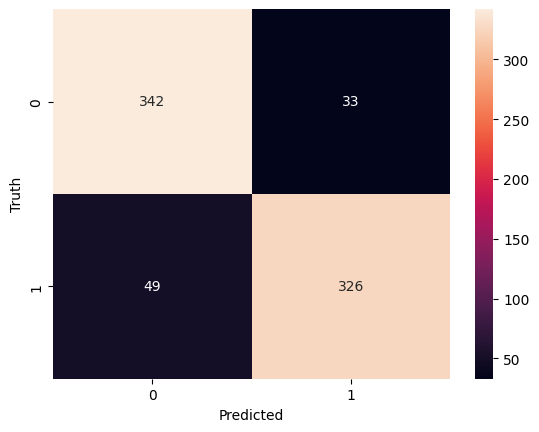

In [45]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [42]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       375
           1       0.91      0.87      0.89       375

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750



<h4>Inference</h4>

In [1]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

NameError: name 'model' is not defined